# Coverage statistics / plots of selected sequences

In [1]:
%run "Header.ipynb"
%run "LoadMutationJSONData.ipynb"

### Real quick: what are the average coverages of each sequence?

In [2]:
for seq in SEQS:
    covs = seq2pos2totalcov[seq].values()
    mean_cov = mean(covs)
    median_cov = median(covs)
    print("Sequence {} has average coverage {} and median coverage {}.".format(seq, mean_cov, median_cov))

Sequence edge_6104 has average coverage 4286.955855524633 and median coverage 4175.0.
Sequence edge_1371 has average coverage 2329.7543243833384 and median coverage 2748.
Sequence edge_2358 has average coverage 3211.3159701100544 and median coverage 2954.


### Plot coverages across genomes

In [20]:
def show_coverage_plot(seq, binlen=None, verbose=False):
    """seq should be an entry in SEQS. binlen can be None (if every position should be plotted),
    or it can be an integer -- in which case this will bin this many positions and just plot
    the average coverage within each bin (bins are not guaranteed to correspond to a uniform number
    of positions in the sequence unless the length of the sequence is exactly divisible by binlen).
    """
    # seq2pos2cov stores positions as strings, but we need to plot them as ints
    int_positions = sorted([int(p) for p in seq2pos2totalcov[seq].keys()])
    
    # quick sanity check: int_positions should not have any gaps
    assert int_positions == list(range(1, len(int_positions) + 1))
    
    str_positions = [str(p) for p in int_positions]
    coverages = [seq2pos2totalcov[seq][pos] for pos in str_positions]
    
    title = "{}: Coverage across genome (length {:,} bp)".format(seq2name[seq], len(int_positions))
    
    if binlen is None:
        pyplot.scatter(int_positions, coverages, c=SCATTERPLOT_PT_COLOR)
    else:
        seqlen = len(int_positions)
        if verbose: print("Doing binning. Seq len for {} is {}".format(seq, seqlen))
        if binlen < 1 or binlen > seqlen:
            # A bin length of 1 shouldn't change anything, compared with binlen=None (since at that
            # point each bin maps one-to-one to a position); a bin length equal to the sequence length
            # just transforms this into plotting a single point with the average coverage across the
            # whole sequence. Anything below or above either of these makes no sense.
            raise ValueError("binlen is outside of [1, seq length].")
        binned_positions = []
        binned_coverages = []
        left_pos = 1
        while left_pos + binlen - 1 <= seqlen:
            # The -1 is needed to fit things in properly.
            # For example, say our sequence is ABCDEFGHIJKLMNOP (start = 1, end = 16).
            # Bins w/ length 3:                1234567890123456
            #                                  ---===---===---=
            # The [left pos, right pos] intervals are:
            # [1, 3], [4, 6], [7, 9], [10, 12], [13, 15], [16]
            right_pos = left_pos + binlen - 1
            binned_positions.append((left_pos + right_pos) / 2)
            positions = range(left_pos, right_pos + 1)
            mean_cov = mean([coverages[p - 1] for p in positions])
            binned_coverages.append(mean_cov)
            if verbose: print("Created bin for [{}, {}]".format(left_pos, right_pos))
            left_pos = right_pos + 1

        # Unless seqlen was evenly divisible by binlen, there will be some extra positions not
        # in any bins yet (at the right end of the sequence). Create a new bin to hold these.
        if left_pos <= seqlen:
            positions = range(left_pos, seqlen + 1)
            binned_positions.append((positions[0] + positions[-1]) / 2)
            mean_cov = mean([coverages[p - 1] for p in positions])
            binned_coverages.append(mean_cov)
            if verbose: print("Created extra bin for [{}, {}]".format(positions[0], positions[-1]))
            title += "\nEvery dot but the rightmost represents a bin of {:,} bp.".format(binlen)
            title += " The rightmost dot is a bin of {:,} bp.".format(len(positions))
        else:
            title += "\nEvery dot represents a bin of {:,} bp.".format(binlen)

        pyplot.scatter(binned_positions, binned_coverages, c=SCATTERPLOT_PT_COLOR)
        
    pyplot.title(title)
    pyplot.xlabel("Sequence position")
    if binlen is None:
        pyplot.ylabel("Number of reads aligned to this position")
    else:
        pyplot.ylabel("Average number of reads aligned\nto all positions within each bin")
    
    # Limit the number of ticks on the x-axis, to avoid overlapping position labels.
    # https://stackoverflow.com/a/13418954
    pyplot.locator_params(axis="x", nbins=10)
    
    use_thousands_sep(pyplot.gca().xaxis)
    use_thousands_sep(pyplot.gca().yaxis)
    
    pyplot.ylim(0)
    
    # Make figure wide: https://stackoverflow.com/a/4306340
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 5)
    pyplot.show()

#### Coverages: no binning, one dot per position

In [10]:
# show_coverage_plot("edge_6104")
# show_coverage_plot("edge_1371")
# show_coverage_plot("edge_2358")

#### Coverages: with binning every 1 kbp

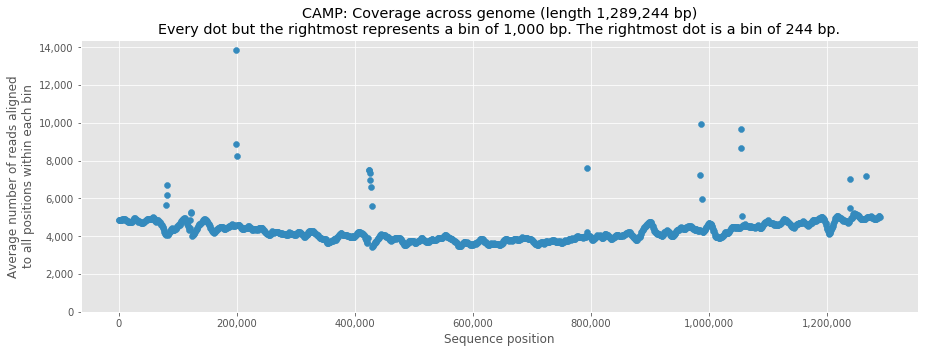

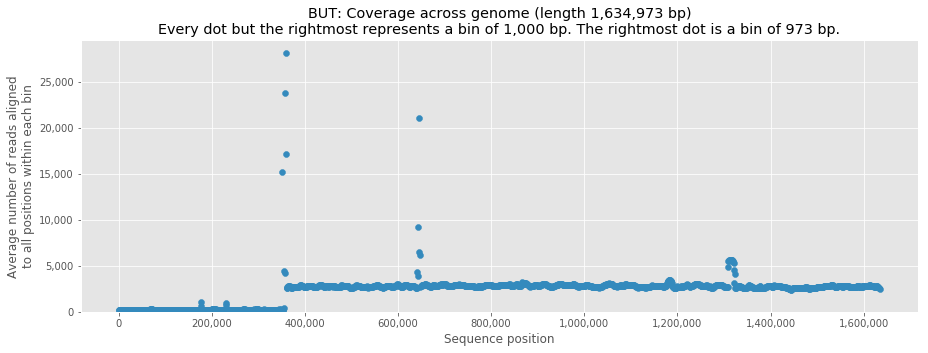

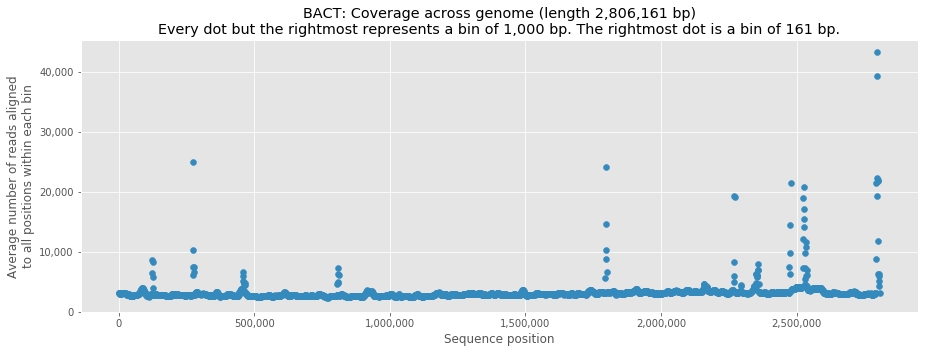

In [21]:
show_coverage_plot("edge_6104", binlen=1000)
show_coverage_plot("edge_1371", binlen=1000)
show_coverage_plot("edge_2358", binlen=1000)